In [1]:
from dataclasses import dataclass
from typing import Dict, List, Union

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from scipy.stats import bernoulli, expon

import warnings
warnings.filterwarnings('ignore')

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
RANDOM_SEED = 4000
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

plotting_defaults = dict(
    bins=50,
    kind="hist",
    textsize=10,
)

In [3]:
@dataclass
class BetaPrior:
    alpha: float
    beta: float

@dataclass
class BinomialData:
    trials: int
    successes: int

In [4]:
class ConversionModelTwoVariant:
    def __init__(self, priors: BetaPrior):
        self.priors = priors

    def create_model(self, data: List[BinomialData]) -> pm.Model:
        trials = [d.trials for d in data]
        successes = [d.successes for d in data]
        with pm.Model() as model:
            p = pm.Beta("p", alpha=self.priors.alpha, beta=self.priors.beta, shape=2)
            obs = pm.Binomial("y", n=trials, p=p, shape=2, observed=successes)
            reluplift = pm.Deterministic("reluplift_b", p[1] / p[0] - 1)
        return model

Sampling: [p, y]
Sampling: [p, y]


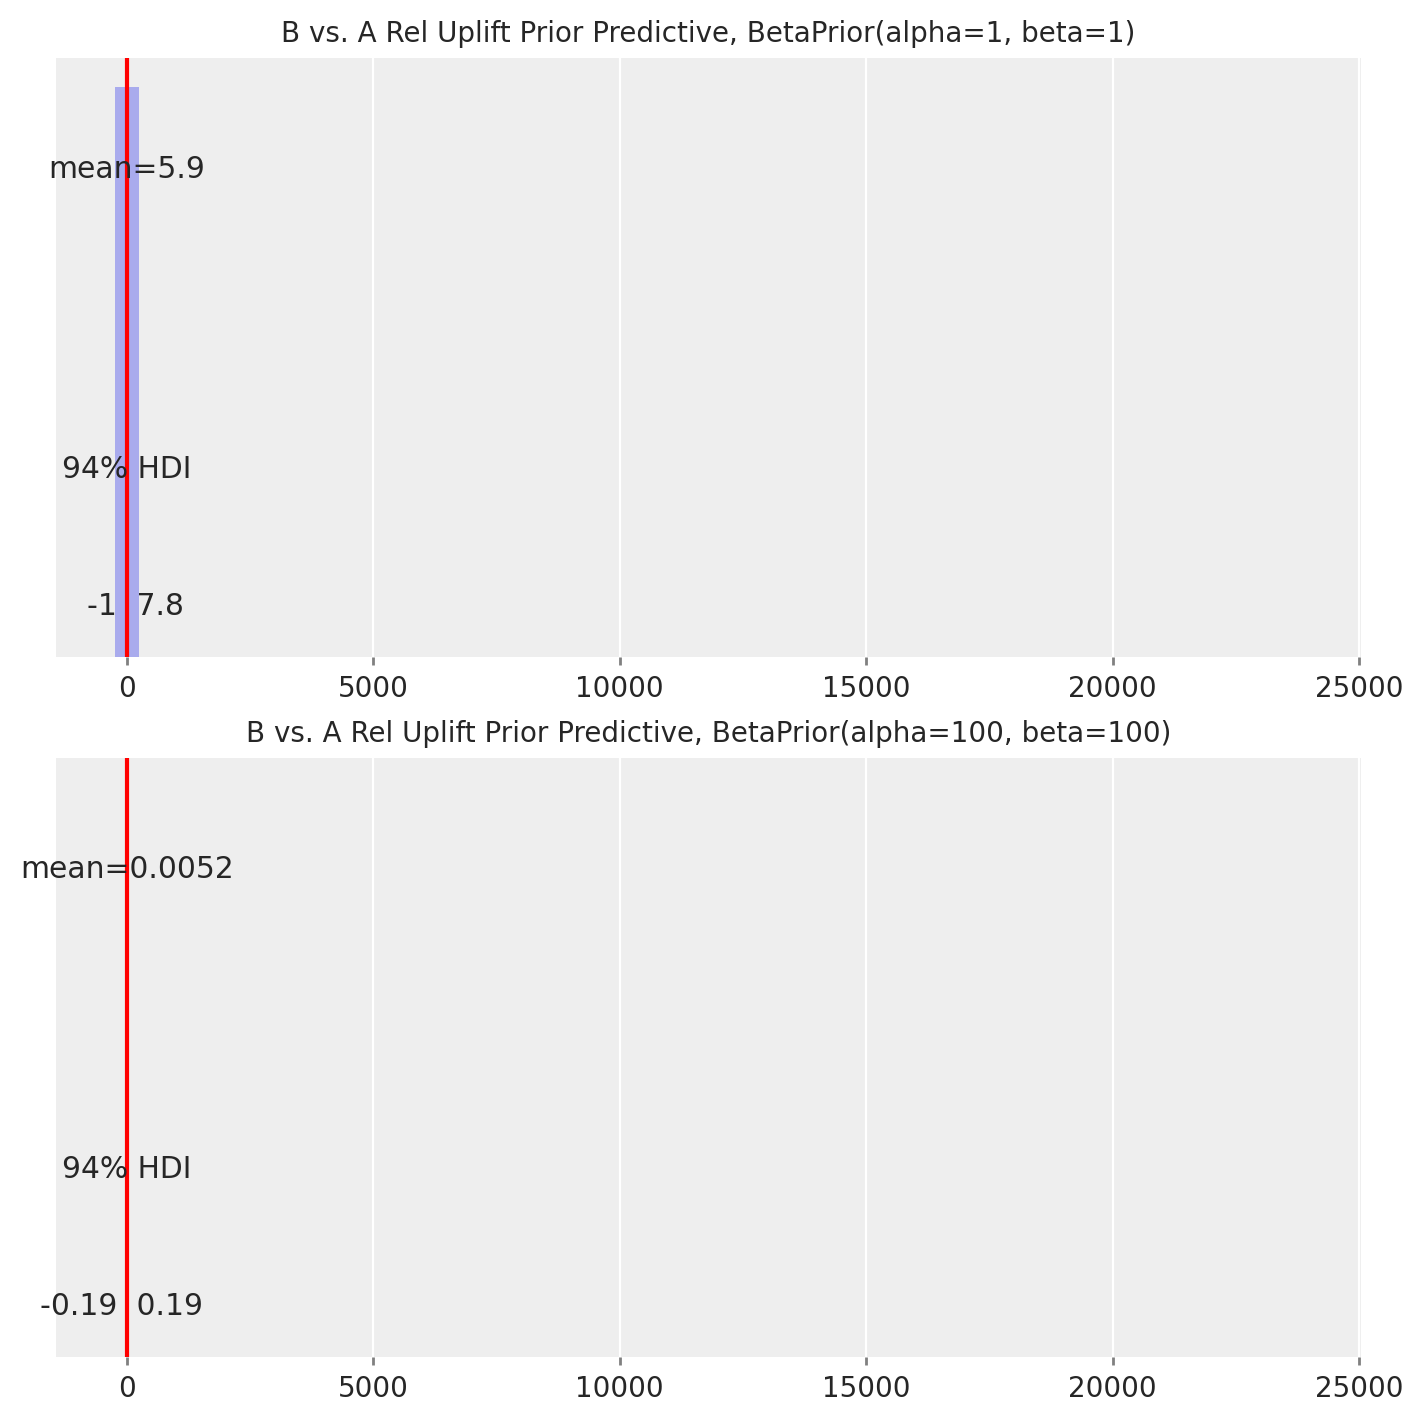

In [14]:
weak_prior = ConversionModelTwoVariant(BetaPrior(alpha=1, beta=1))
strong_prior = ConversionModelTwoVariant(BetaPrior(alpha=100, beta=100))

with weak_prior.create_model(data=[BinomialData(1, 1), BinomialData(1, 1)]):
    weak_prior_predictive = pm.sample_prior_predictive(samples=10000, return_inferencedata=False)

with strong_prior.create_model(data=[BinomialData(1, 1), BinomialData(1, 1)]):
    strong_prior_predictive = pm.sample_prior_predictive(samples=10000, return_inferencedata=False)

fig, axs = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
az.plot_posterior(weak_prior_predictive["reluplift_b"], ax=axs[0], **plotting_defaults)
axs[0].set_title(f"B vs. A Rel Uplift Prior Predictive, {weak_prior.priors}", fontsize=10)
axs[0].axvline(x=0, color="red")
az.plot_posterior(strong_prior_predictive["reluplift_b"], ax=axs[1], **plotting_defaults)
axs[1].set_title(f"B vs. A Rel Uplift Prior Predictive, {strong_prior.priors}", fontsize=10)
axs[1].axvline(x=0, color="red");

In [6]:
def generate_binomial_data(
    variants: List[str], true_rates: List[str], samples_per_variant: int = 100000
) -> pd.DataFrame:
    data = {}
    for variant, p in zip(variants, true_rates):
        data[variant] = bernoulli.rvs(p, size=samples_per_variant)
    agg = (
        pd.DataFrame(data)
        .aggregate(["count", "sum"])
        .rename(index={"count": "trials", "sum": "successes"})
    )
    return agg

In [13]:
# Example generated data
generate_binomial_data(["A", "B"], [0.23, 0.23])

,A,B
trials,100000,100000
successes,23262,23062


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


Generated Data:                 A       B
trials     100000  100000
successes   18088   23001
Running weak prior model...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


Running strong prior model...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 1 seconds.


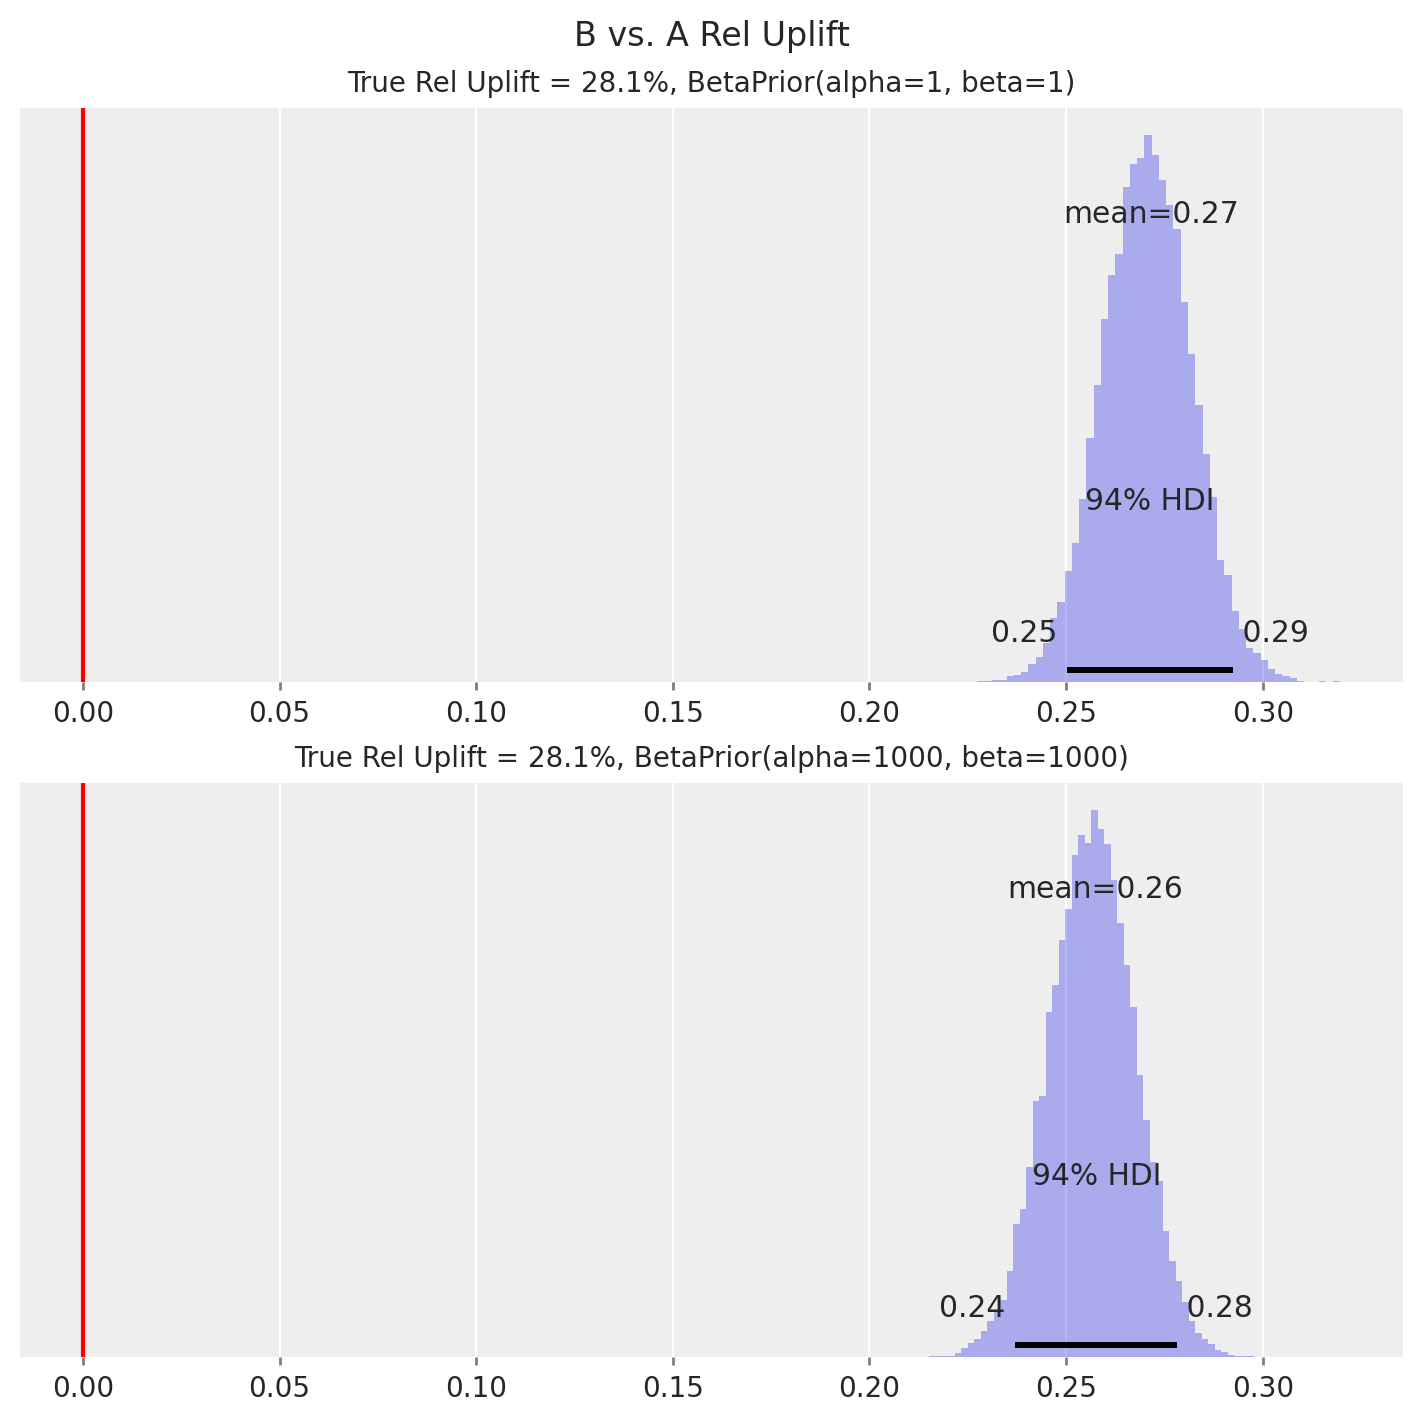

In [25]:
def run_scenario_twovariant(
    variants: List[str],
    true_rates: List[float],
    samples_per_variant: int,
    weak_prior: BetaPrior,
    strong_prior: BetaPrior,
) -> None:
    
    # Set initialization values
    init_vals = {'p': np.array([0.5, 0.5])}
    
    # Generate data
    generated = generate_binomial_data(variants, true_rates, samples_per_variant)
    print("Generated Data:", generated)
    data = [BinomialData(**generated[v].to_dict()) for v in variants]

    # Run weak prior model
    try:
        with ConversionModelTwoVariant(priors=weak_prior).create_model(data) as model:
            print("Running weak prior model...")
            trace_weak = pm.sample(draws=5000, init="adapt_diag", initvals=init_vals)
    except Exception as e:
        print(f"Error in weak prior model: {e}")
        return
    
    # Run strong prior model
    try:
        with ConversionModelTwoVariant(priors=strong_prior).create_model(data) as model:
            print("Running strong prior model...")
            trace_strong = pm.sample(draws=5000, init="adapt_diag", initvals=init_vals)
    except Exception as e:
        print(f"Error in strong prior model: {e}")
        return

    # Plot results
    true_rel_uplift = true_rates[1] / true_rates[0] - 1
    fig, axs = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
    
    az.plot_posterior(trace_weak.posterior["reluplift_b"], ax=axs[0], **plotting_defaults)
    axs[0].set_title(f"True Rel Uplift = {true_rel_uplift:.1%}, {weak_prior}", fontsize=10)
    axs[0].axvline(x=0, color="red")
    
    az.plot_posterior(trace_strong.posterior["reluplift_b"], ax=axs[1], **plotting_defaults)
    axs[1].set_title(f"True Rel Uplift = {true_rel_uplift:.1%}, {strong_prior}", fontsize=10)
    axs[1].axvline(x=0, color="red")
    
    fig.suptitle("B vs. A Rel Uplift")
    plt.show()
    
    return trace_weak, trace_strong

# Run scenario with adjusted priors
trace_weak, trace_strong = run_scenario_twovariant(
    variants=["A", "B"],
    true_rates=[0.18, 0.23062],  # Success rates for both variants
    samples_per_variant=100000,
    weak_prior=BetaPrior(alpha=1, beta=1),  # Uniform weak prior
    strong_prior=BetaPrior(alpha=1000, beta=1000),  # Moderately strong prior
)

In [26]:
class ConversionModel:
    def __init__(self, priors: BetaPrior):
        self.priors = priors

    def create_model(self, data: List[BinomialData], comparison_method) -> pm.Model:
        num_variants = len(data)
        trials = [d.trials for d in data]
        successes = [d.successes for d in data]
        with pm.Model() as model:
            p = pm.Beta("p", alpha=self.priors.alpha, beta=self.priors.beta, shape=num_variants)
            y = pm.Binomial("y", n=trials, p=p, observed=successes, shape=num_variants)
            reluplift = []
            for i in range(num_variants):
                if comparison_method == "compare_to_control":
                    comparison = p[0]
                elif comparison_method == "best_of_rest":
                    others = [p[j] for j in range(num_variants) if j != i]
                    if len(others) > 1:
                        comparison = pm.math.maximum(*others)
                    else:
                        comparison = others[0]
                else:
                    raise ValueError(f"comparison method {comparison_method} not recognised.")
                reluplift.append(pm.Deterministic(f"reluplift_{i}", p[i] / comparison - 1))
        return model

In [27]:
def run_scenario_bernoulli(
    variants: List[str],
    true_rates: List[float],
    samples_per_variant: int,
    priors: BetaPrior,
    comparison_method: str,
) -> az.InferenceData:
    generated = generate_binomial_data(variants, true_rates, samples_per_variant)
    data = [BinomialData(**generated[v].to_dict()) for v in variants]
    with ConversionModel(priors).create_model(data=data, comparison_method=comparison_method):
        trace = pm.sample(draws=5000)

    n_plots = len(variants)
    fig, axs = plt.subplots(nrows=n_plots, ncols=1, figsize=(3 * n_plots, 7), sharex=True)
    for i, variant in enumerate(variants):
        if i == 0 and comparison_method == "compare_to_control":
            axs[i].set_yticks([])
        else:
            az.plot_posterior(trace.posterior[f"reluplift_{i}"], ax=axs[i], **plotting_defaults)
        axs[i].set_title(f"Rel Uplift {variant}, True Rate = {true_rates[i]:.2%}", fontsize=10)
        axs[i].axvline(x=0, color="red")
    fig.suptitle(f"Method {comparison_method}, {priors}")

    return trace

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2 seconds.


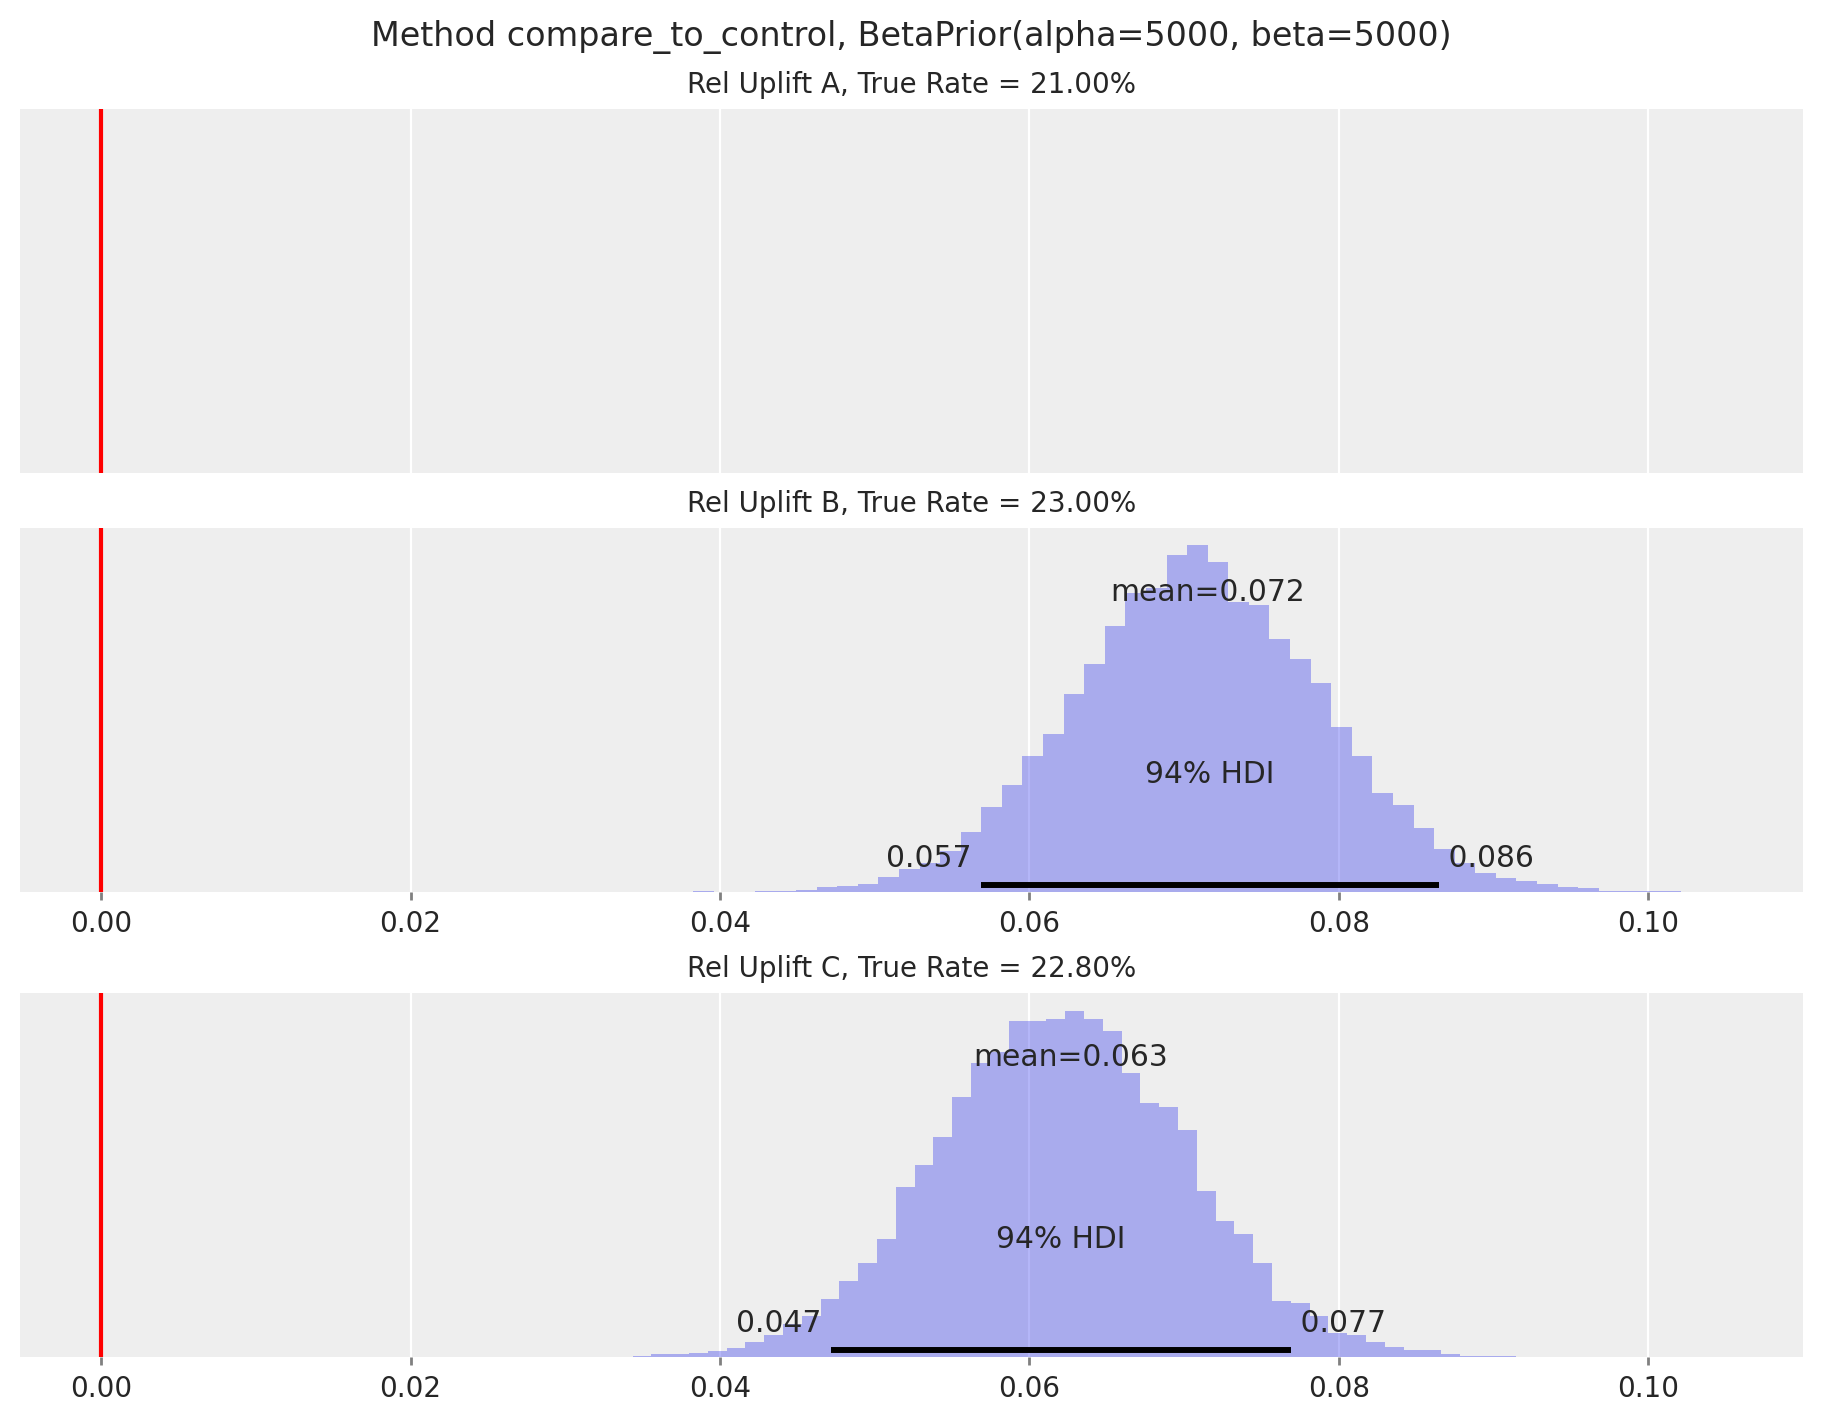

In [28]:
_ = run_scenario_bernoulli(
    variants=["A", "B", "C"],
    true_rates=[0.21, 0.23, 0.228],
    samples_per_variant=100000,
    priors=BetaPrior(alpha=5000, beta=5000),
    comparison_method="compare_to_control",
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2 seconds.


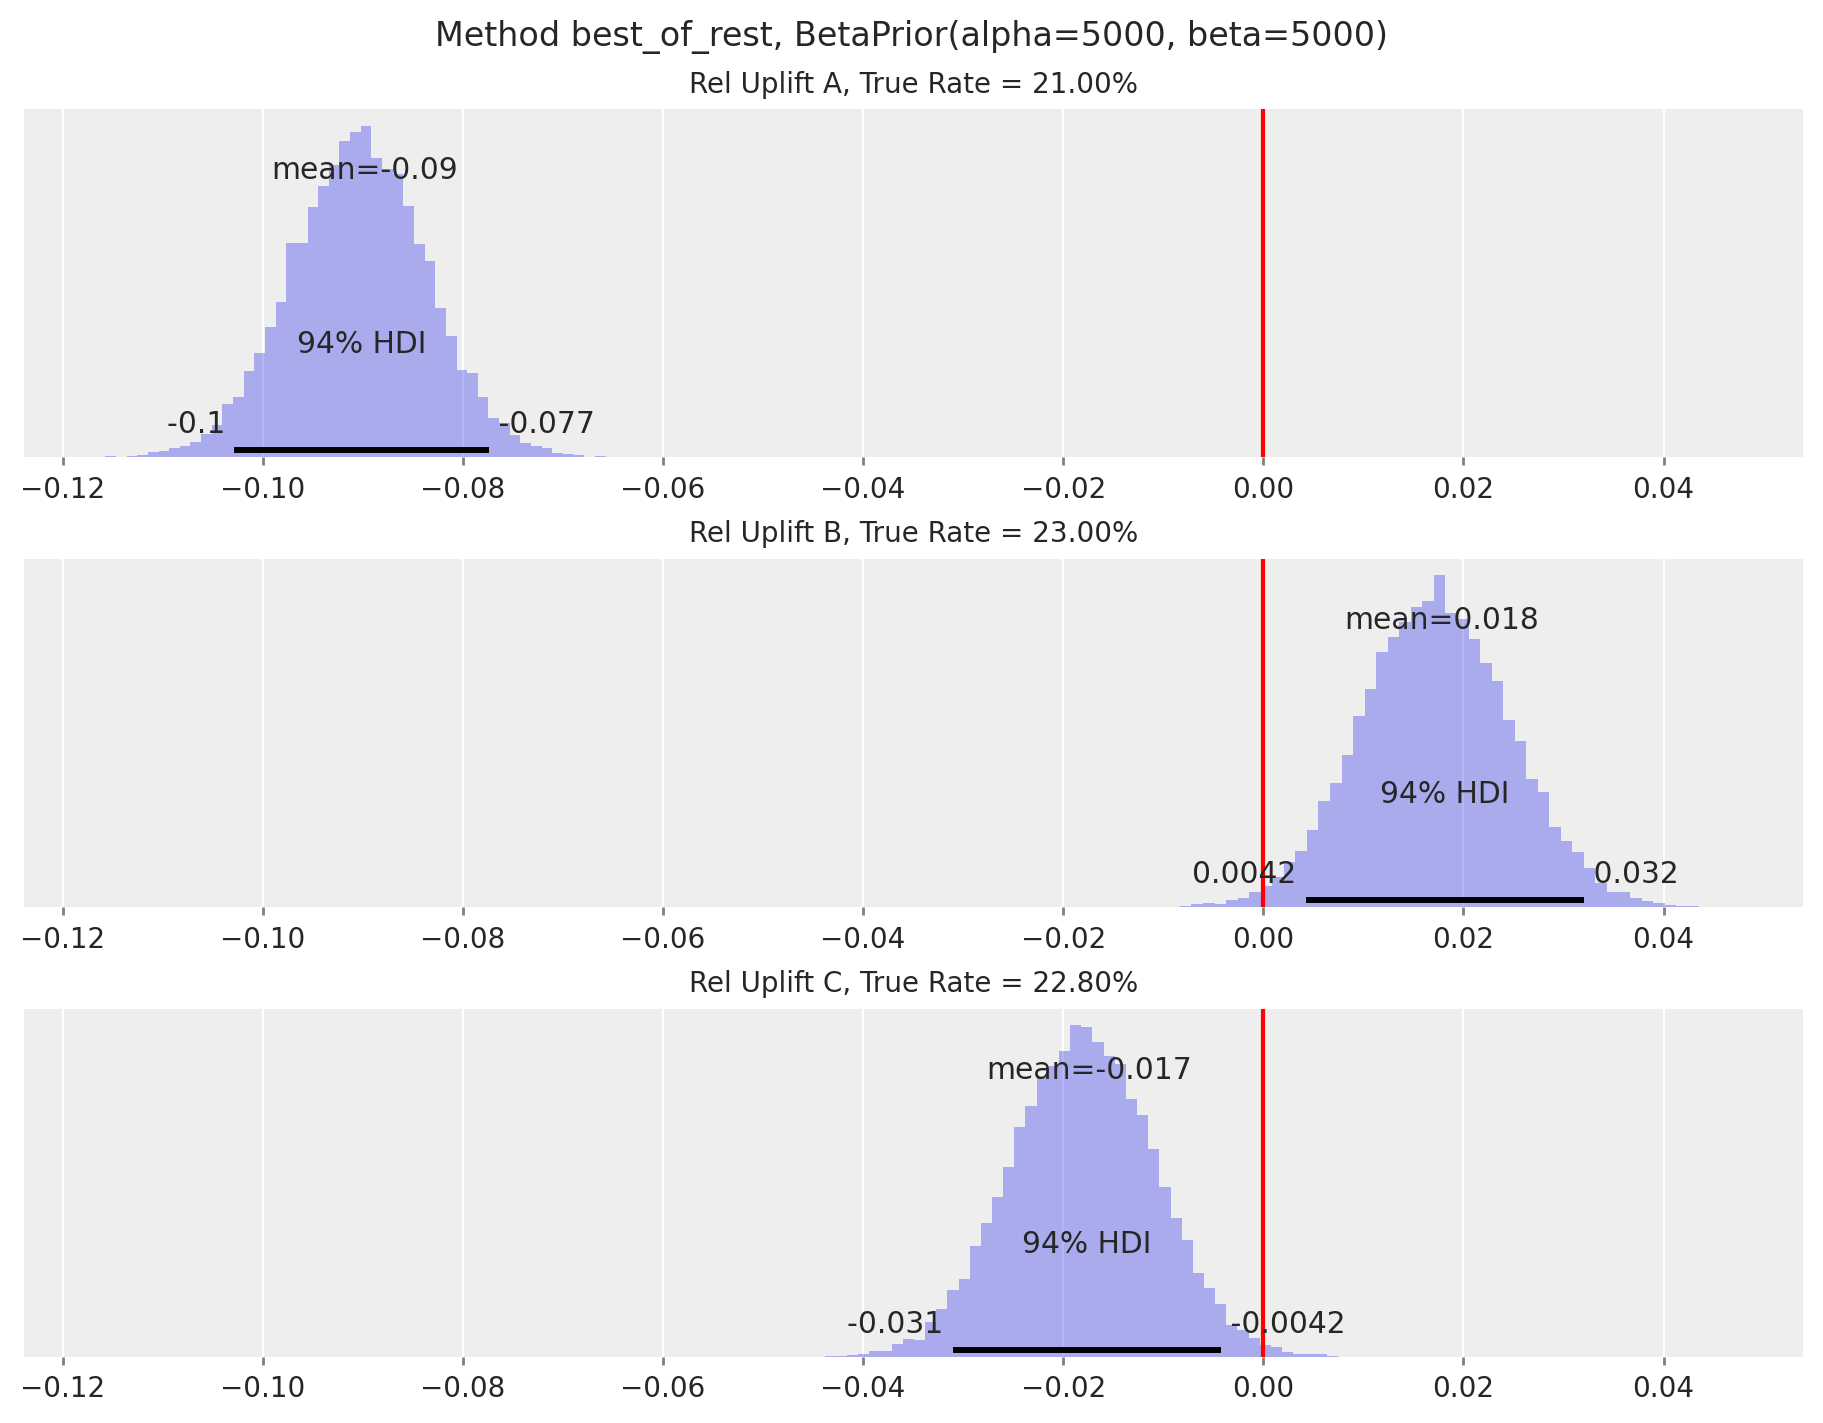

In [29]:
_ = run_scenario_bernoulli(
    variants=["A", "B", "C"],
    true_rates=[0.21, 0.23, 0.228],
    samples_per_variant=100000,
    priors=BetaPrior(alpha=5000, beta=5000),
    comparison_method="best_of_rest",
)

In [31]:
@dataclass
class GammaPrior:
    alpha: float
    beta: float

@dataclass
class RevenueData:
    visitors: int
    purchased: int
    total_revenue: float



In [32]:
class RevenueModel:
    def __init__(self, conversion_rate_prior: BetaPrior, mean_purchase_prior: GammaPrior):
        self.conversion_rate_prior = conversion_rate_prior
        self.mean_purchase_prior = mean_purchase_prior

    def create_model(self, data: List[RevenueData], comparison_method: str) -> pm.Model:
        num_variants = len(data)
        visitors = [d.visitors for d in data]
        purchased = [d.purchased for d in data]
        total_revenue = [d.total_revenue for d in data]

        with pm.Model() as model:
            theta = pm.Beta(
                "theta",
                alpha=self.conversion_rate_prior.alpha,
                beta=self.conversion_rate_prior.beta,
                shape=num_variants,
            )
            lam = pm.Gamma(
                "lam",
                alpha=self.mean_purchase_prior.alpha,
                beta=self.mean_purchase_prior.beta,
                shape=num_variants,
            )
            converted = pm.Binomial(
                "converted", n=visitors, p=theta, observed=purchased, shape=num_variants
            )
            revenue = pm.Gamma(
                "revenue", alpha=purchased, beta=lam, observed=total_revenue, shape=num_variants
            )
            revenue_per_visitor = pm.Deterministic("revenue_per_visitor", theta * (1 / lam))
            theta_reluplift = []
            reciprocal_lam_reluplift = []
            reluplift = []
            for i in range(num_variants):
                if comparison_method == "compare_to_control":
                    comparison_theta = theta[0]
                    comparison_lam = 1 / lam[0]
                    comparison_rpv = revenue_per_visitor[0]
                elif comparison_method == "best_of_rest":
                    others_theta = [theta[j] for j in range(num_variants) if j != i]
                    others_lam = [1 / lam[j] for j in range(num_variants) if j != i]
                    others_rpv = [revenue_per_visitor[j] for j in range(num_variants) if j != i]
                    if len(others_rpv) > 1:
                        comparison_theta = pm.math.maximum(*others_theta)
                        comparison_lam = pm.math.maximum(*others_lam)
                        comparison_rpv = pm.math.maximum(*others_rpv)
                    else:
                        comparison_theta = others_theta[0]
                        comparison_lam = others_lam[0]
                        comparison_rpv = others_rpv[0]
                else:
                    raise ValueError(f"comparison method {comparison_method} not recognised.")
                theta_reluplift.append(
                    pm.Deterministic(f"theta_reluplift_{i}", theta[i] / comparison_theta - 1)
                )
                reciprocal_lam_reluplift.append(
                    pm.Deterministic(
                        f"reciprocal_lam_reluplift_{i}", (1 / lam[i]) / comparison_lam - 1
                    )
                )
                reluplift.append(
                    pm.Deterministic(f"reluplift_{i}", revenue_per_visitor[i] / comparison_rpv - 1)
                )
        return model

Sampling: [converted, lam, revenue, theta]


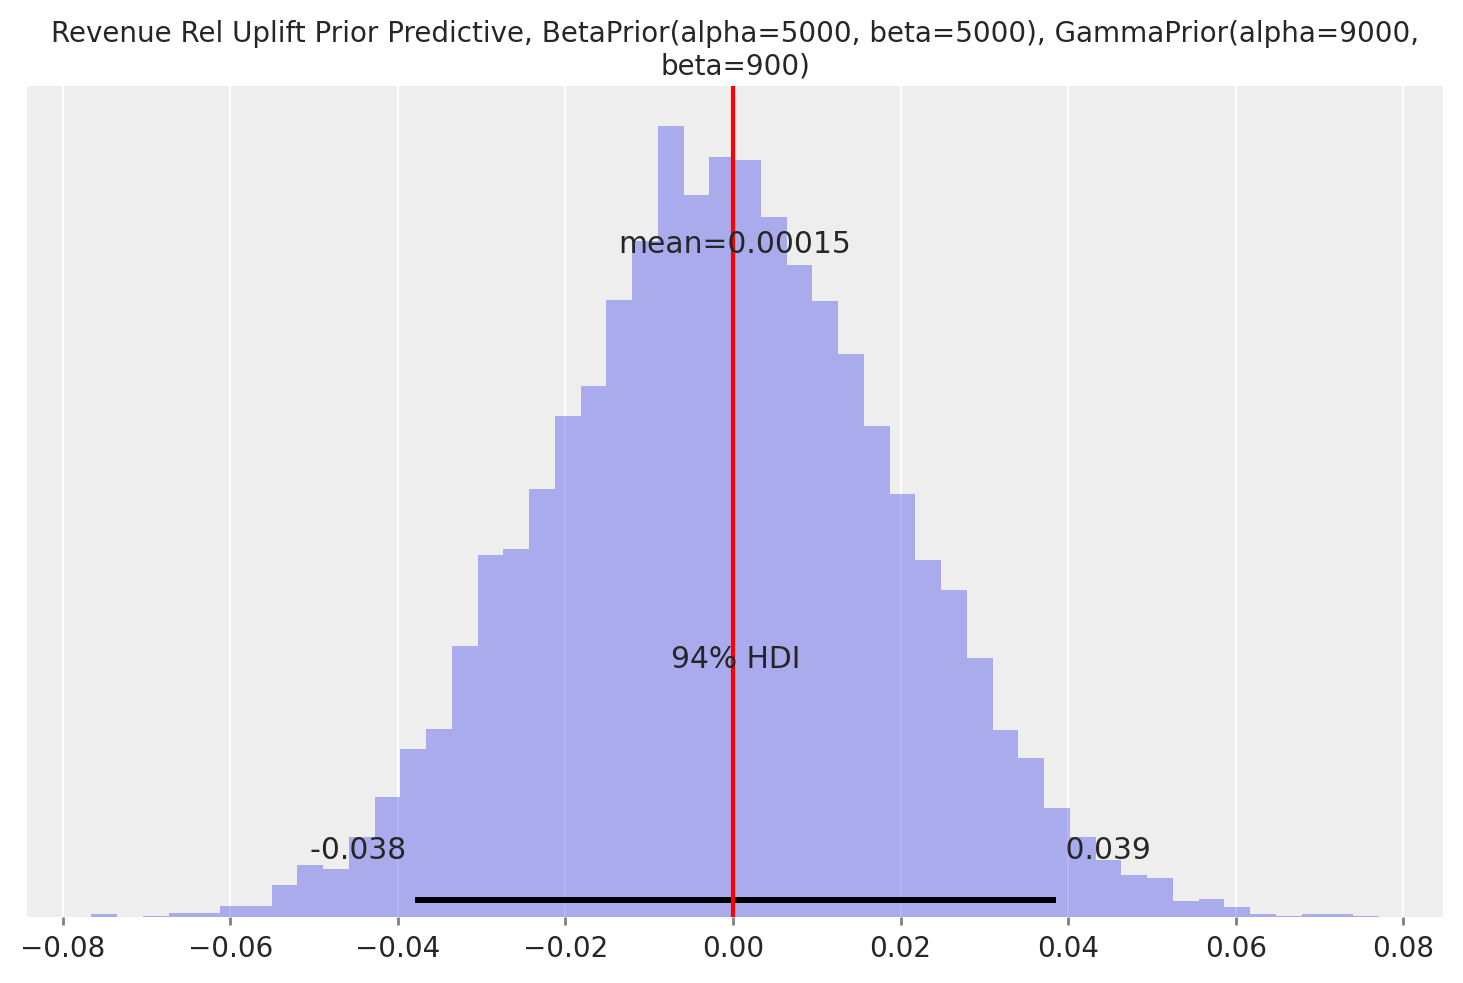

In [33]:
c_prior = BetaPrior(alpha=5000, beta=5000)
mp_prior = GammaPrior(alpha=9000, beta=900)

data = [
    RevenueData(visitors=1, purchased=1, total_revenue=1),
    RevenueData(visitors=1, purchased=1, total_revenue=1),
]

with RevenueModel(c_prior, mp_prior).create_model(data, "best_of_rest"):
    revenue_prior_predictive = pm.sample_prior_predictive(samples=10000, return_inferencedata=False)

fig, ax = plt.subplots()
az.plot_posterior(revenue_prior_predictive["reluplift_1"], ax=ax, **plotting_defaults)
ax.set_title(f"Revenue Rel Uplift Prior Predictive, {c_prior}, {mp_prior}", fontsize=10)
ax.axvline(x=0, color="red");

In [34]:
def generate_revenue_data(
    variants: List[str],
    true_conversion_rates: List[float],
    true_mean_purchase: List[float],
    samples_per_variant: int,
) -> pd.DataFrame:
    converted = {}
    mean_purchase = {}
    for variant, p, mp in zip(variants, true_conversion_rates, true_mean_purchase):
        converted[variant] = bernoulli.rvs(p, size=samples_per_variant)
        mean_purchase[variant] = expon.rvs(scale=mp, size=samples_per_variant)
    converted = pd.DataFrame(converted)
    mean_purchase = pd.DataFrame(mean_purchase)
    revenue = converted * mean_purchase
    agg = pd.concat(
        [
            converted.aggregate(["count", "sum"]).rename(
                index={"count": "visitors", "sum": "purchased"}
            ),
            revenue.aggregate(["sum"]).rename(index={"sum": "total_revenue"}),
        ]
    )
    return agg

In [35]:
def run_scenario_value(
    variants: List[str],
    true_conversion_rates: List[float],
    true_mean_purchase: List[float],
    samples_per_variant: int,
    conversion_rate_prior: BetaPrior,
    mean_purchase_prior: GammaPrior,
    comparison_method: str,
) -> az.InferenceData:
    generated = generate_revenue_data(
        variants, true_conversion_rates, true_mean_purchase, samples_per_variant
    )
    data = [RevenueData(**generated[v].to_dict()) for v in variants]
    with RevenueModel(conversion_rate_prior, mean_purchase_prior).create_model(
        data, comparison_method
    ):
        trace = pm.sample(draws=5000, chains=2, cores=1)

    n_plots = len(variants)
    fig, axs = plt.subplots(nrows=n_plots, ncols=1, figsize=(3 * n_plots, 7), sharex=True)
    for i, variant in enumerate(variants):
        if i == 0 and comparison_method == "compare_to_control":
            axs[i].set_yticks([])
        else:
            az.plot_posterior(trace.posterior[f"reluplift_{i}"], ax=axs[i], **plotting_defaults)
        true_rpv = true_conversion_rates[i] * true_mean_purchase[i]
        axs[i].set_title(f"Rel Uplift {variant}, True RPV = {true_rpv:.2f}", fontsize=10)
        axs[i].axvline(x=0, color="red")
    fig.suptitle(f"Method {comparison_method}, {conversion_rate_prior}, {mean_purchase_prior}")

    return trace

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, lam]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


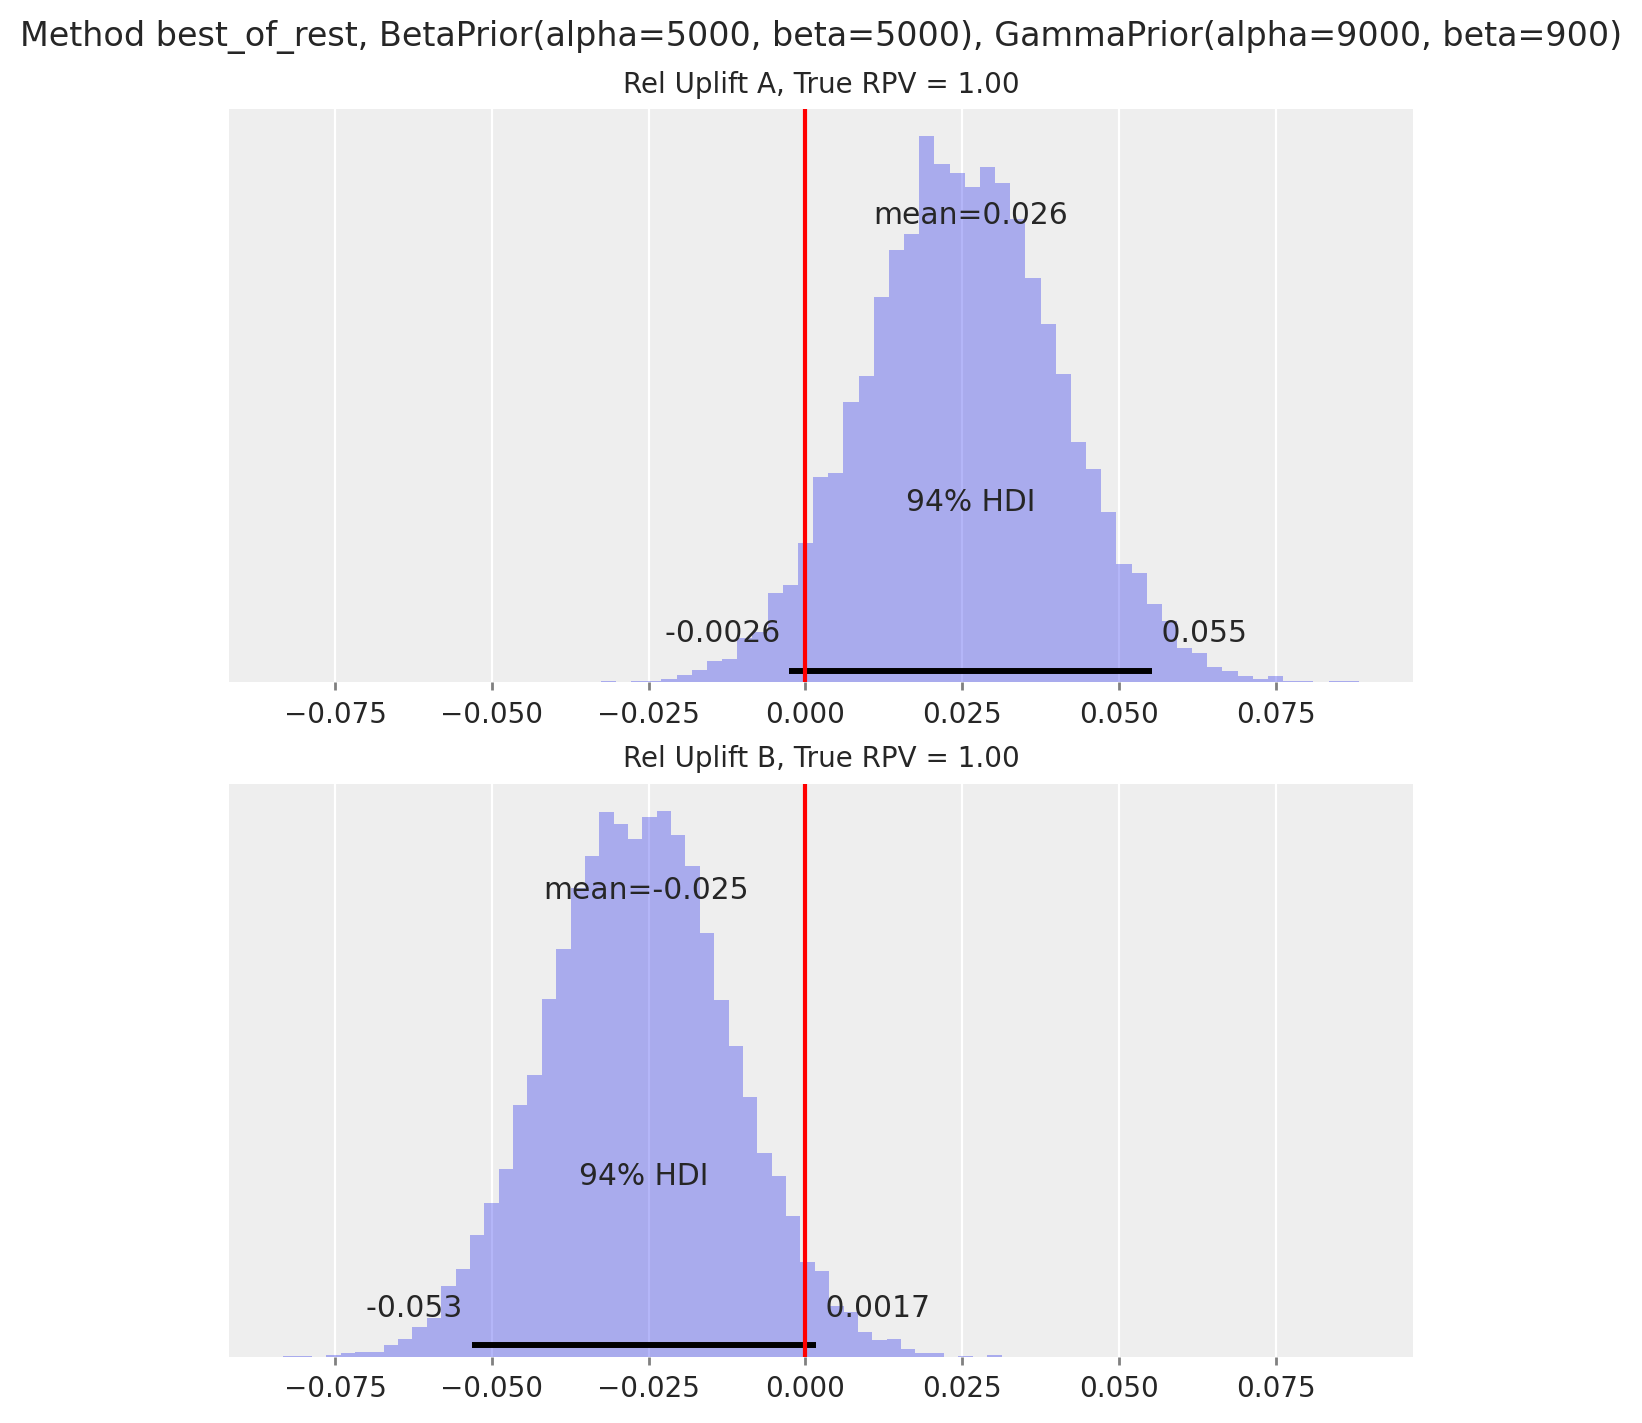

In [36]:
_ = run_scenario_value(
    variants=["A", "B"],
    true_conversion_rates=[0.1, 0.1],
    true_mean_purchase=[10, 10],
    samples_per_variant=100000,
    conversion_rate_prior=BetaPrior(alpha=5000, beta=5000),
    mean_purchase_prior=GammaPrior(alpha=9000, beta=900),
    comparison_method="best_of_rest",
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, lam]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


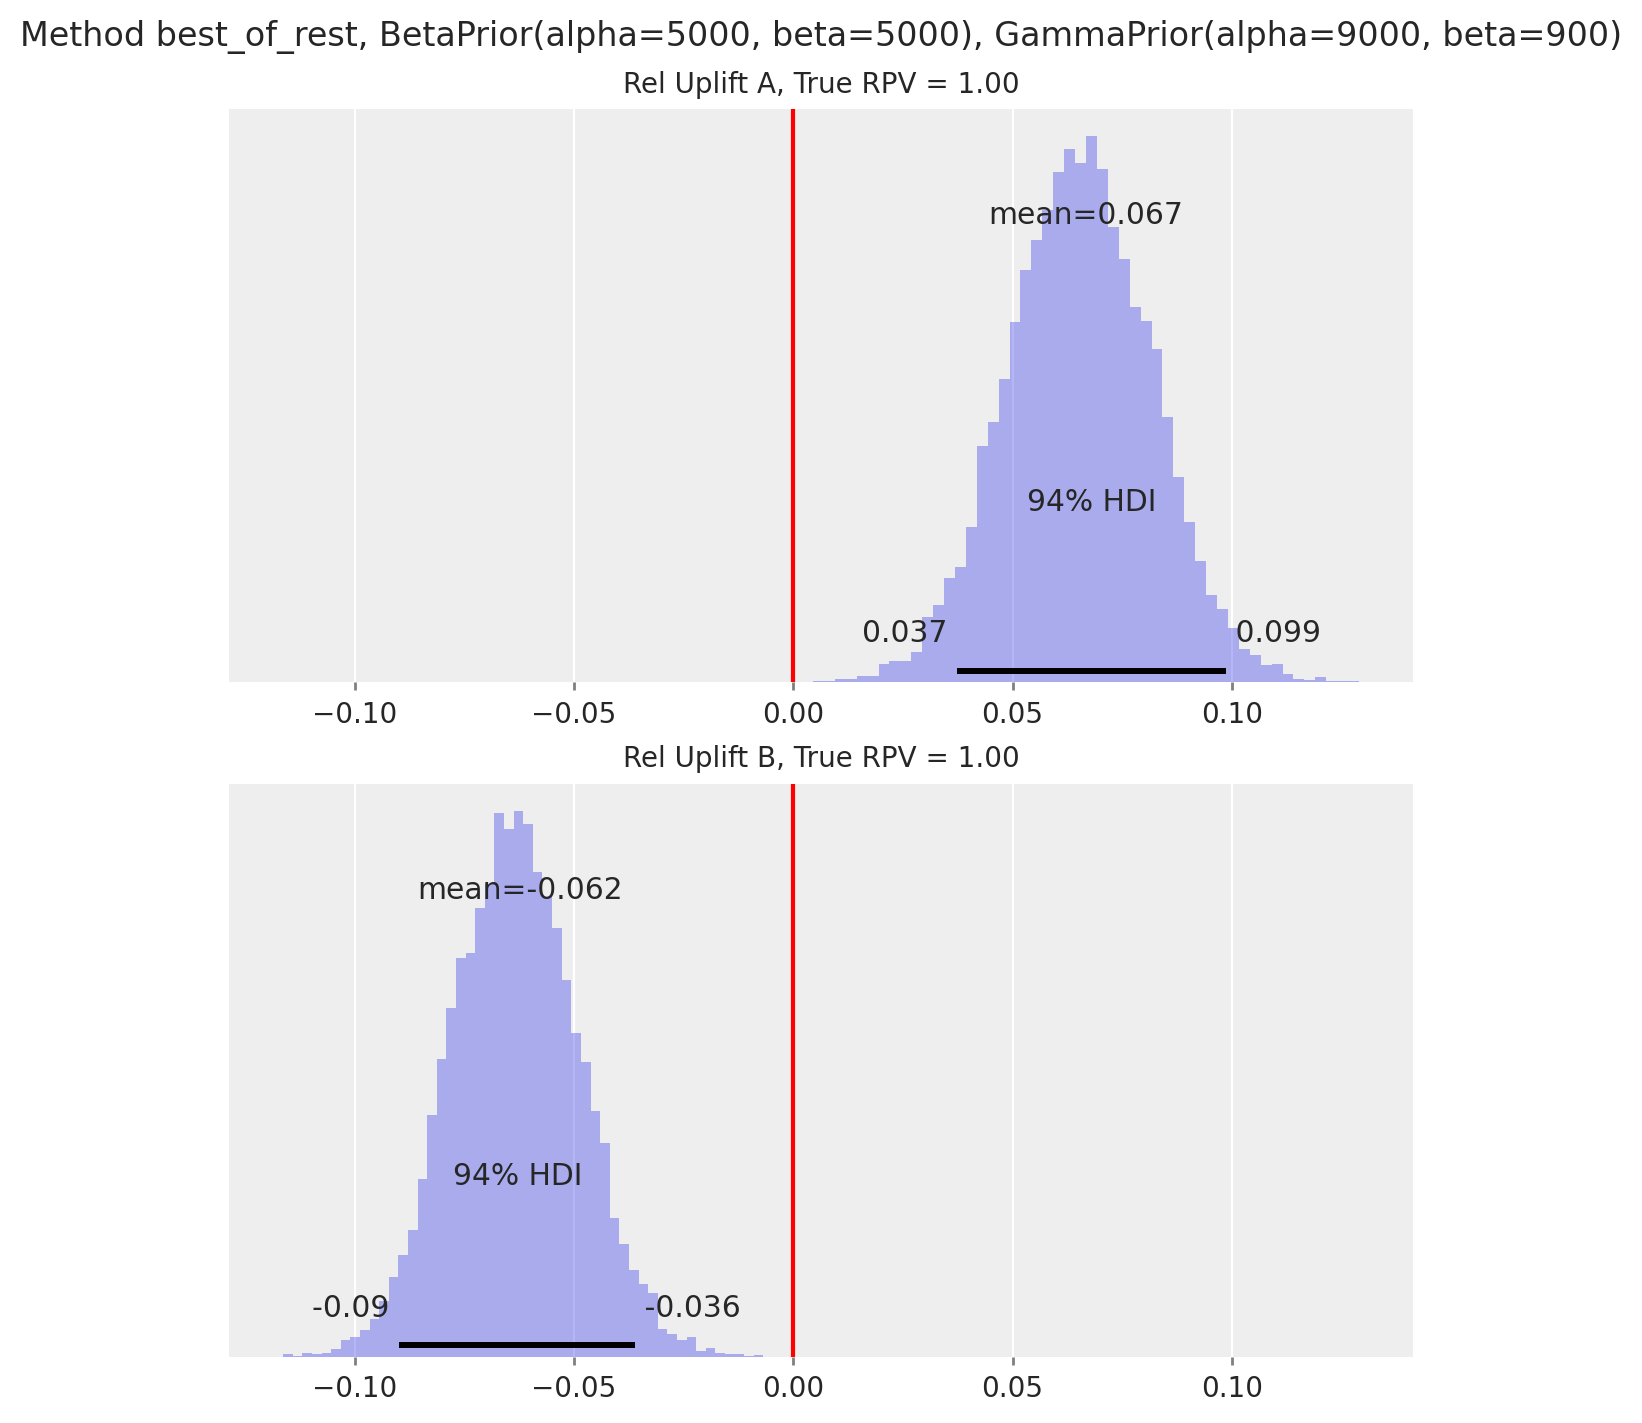

In [37]:
scenario_value_2 = run_scenario_value(
    variants=["A", "B"],
    true_conversion_rates=[0.1, 0.08],
    true_mean_purchase=[10, 12.5],
    samples_per_variant=100000,
    conversion_rate_prior=BetaPrior(alpha=5000, beta=5000),
    mean_purchase_prior=GammaPrior(alpha=9000, beta=900),
    comparison_method="best_of_rest",
)

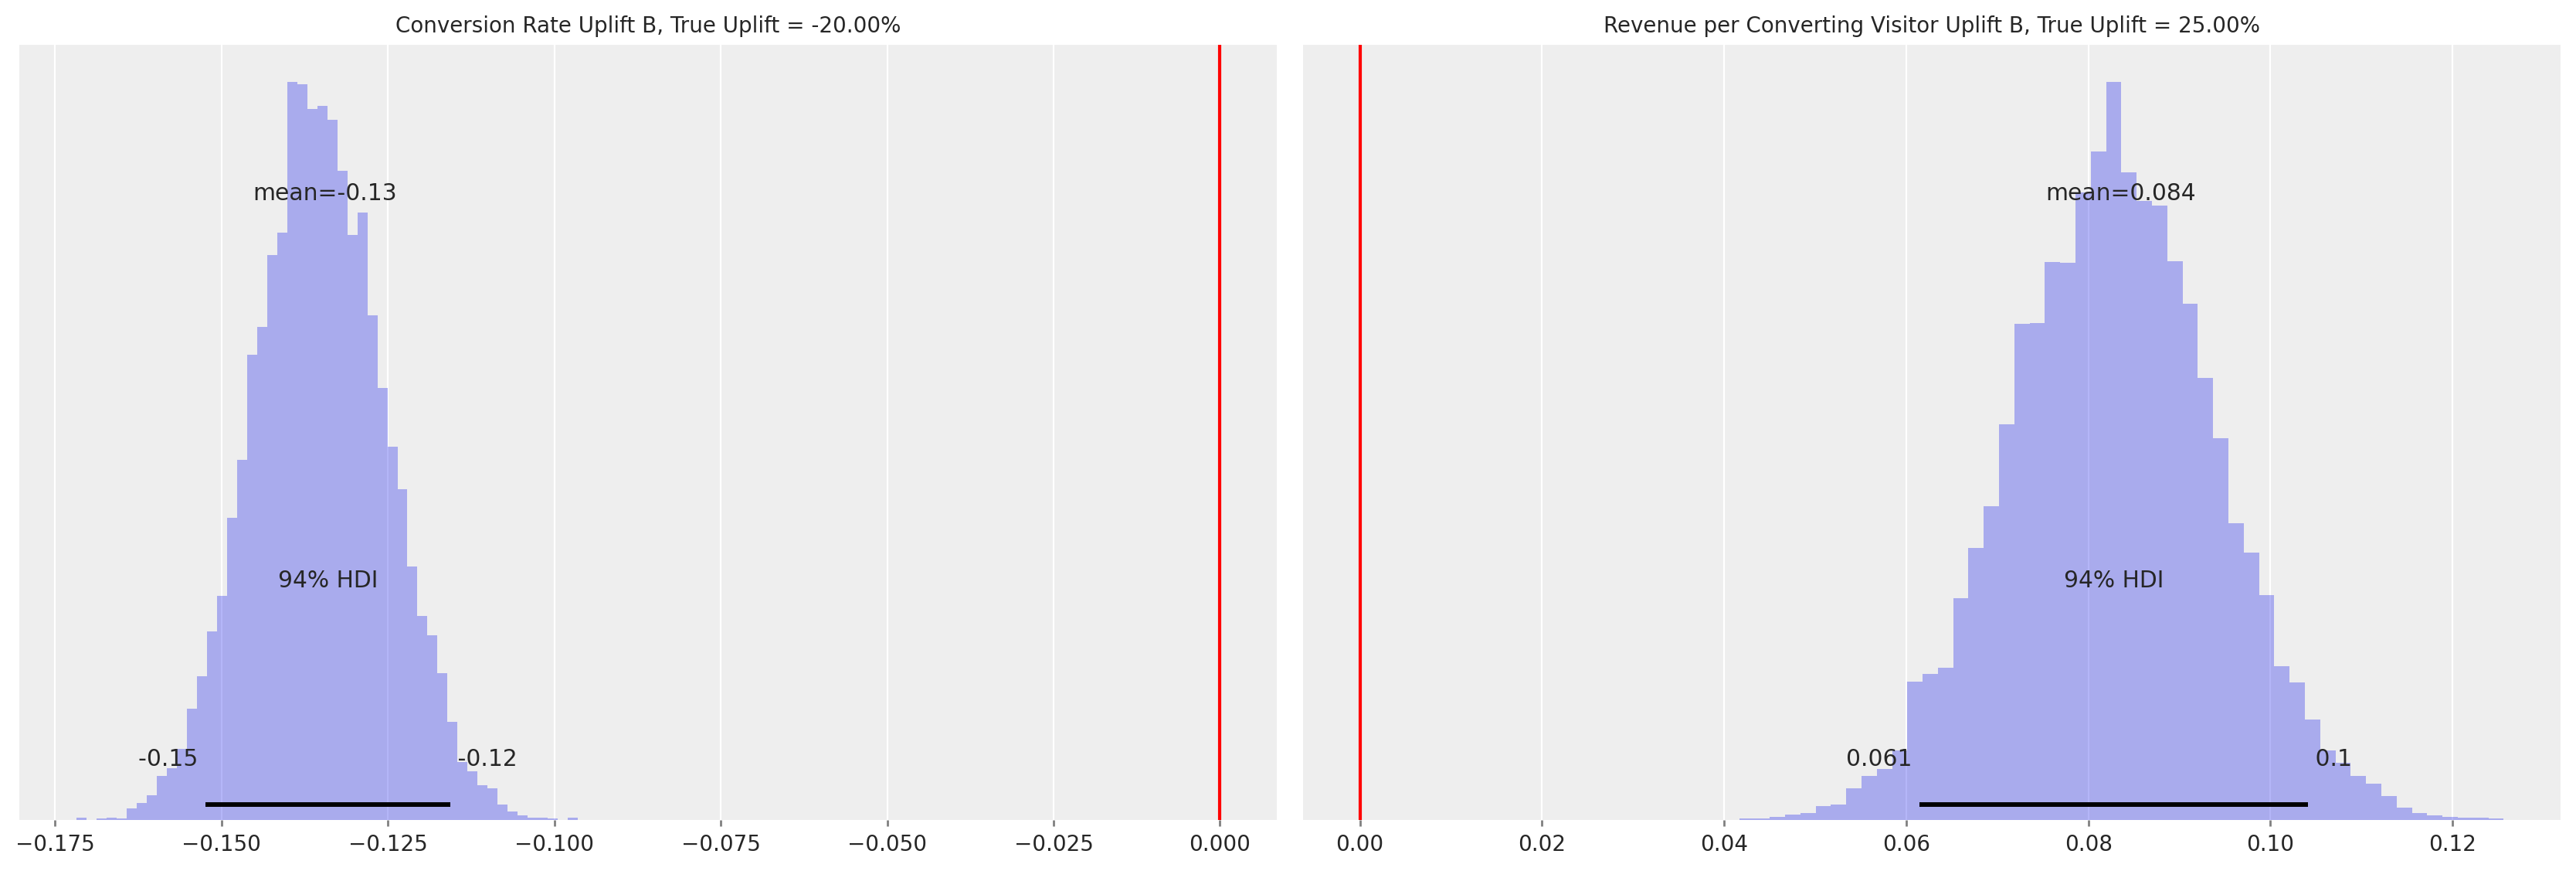

In [38]:
axs = az.plot_posterior(
    scenario_value_2,
    var_names=["theta_reluplift_1", "reciprocal_lam_reluplift_1"],
    **plotting_defaults,
)
axs[0].set_title(f"Conversion Rate Uplift B, True Uplift = {(0.04 / 0.05 - 1):.2%}", fontsize=10)
axs[0].axvline(x=0, color="red")
axs[1].set_title(
    f"Revenue per Converting Visitor Uplift B, True Uplift = {(25 / 20 - 1):.2%}", fontsize=10
)
axs[1].axvline(x=0, color="red");

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, lam]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


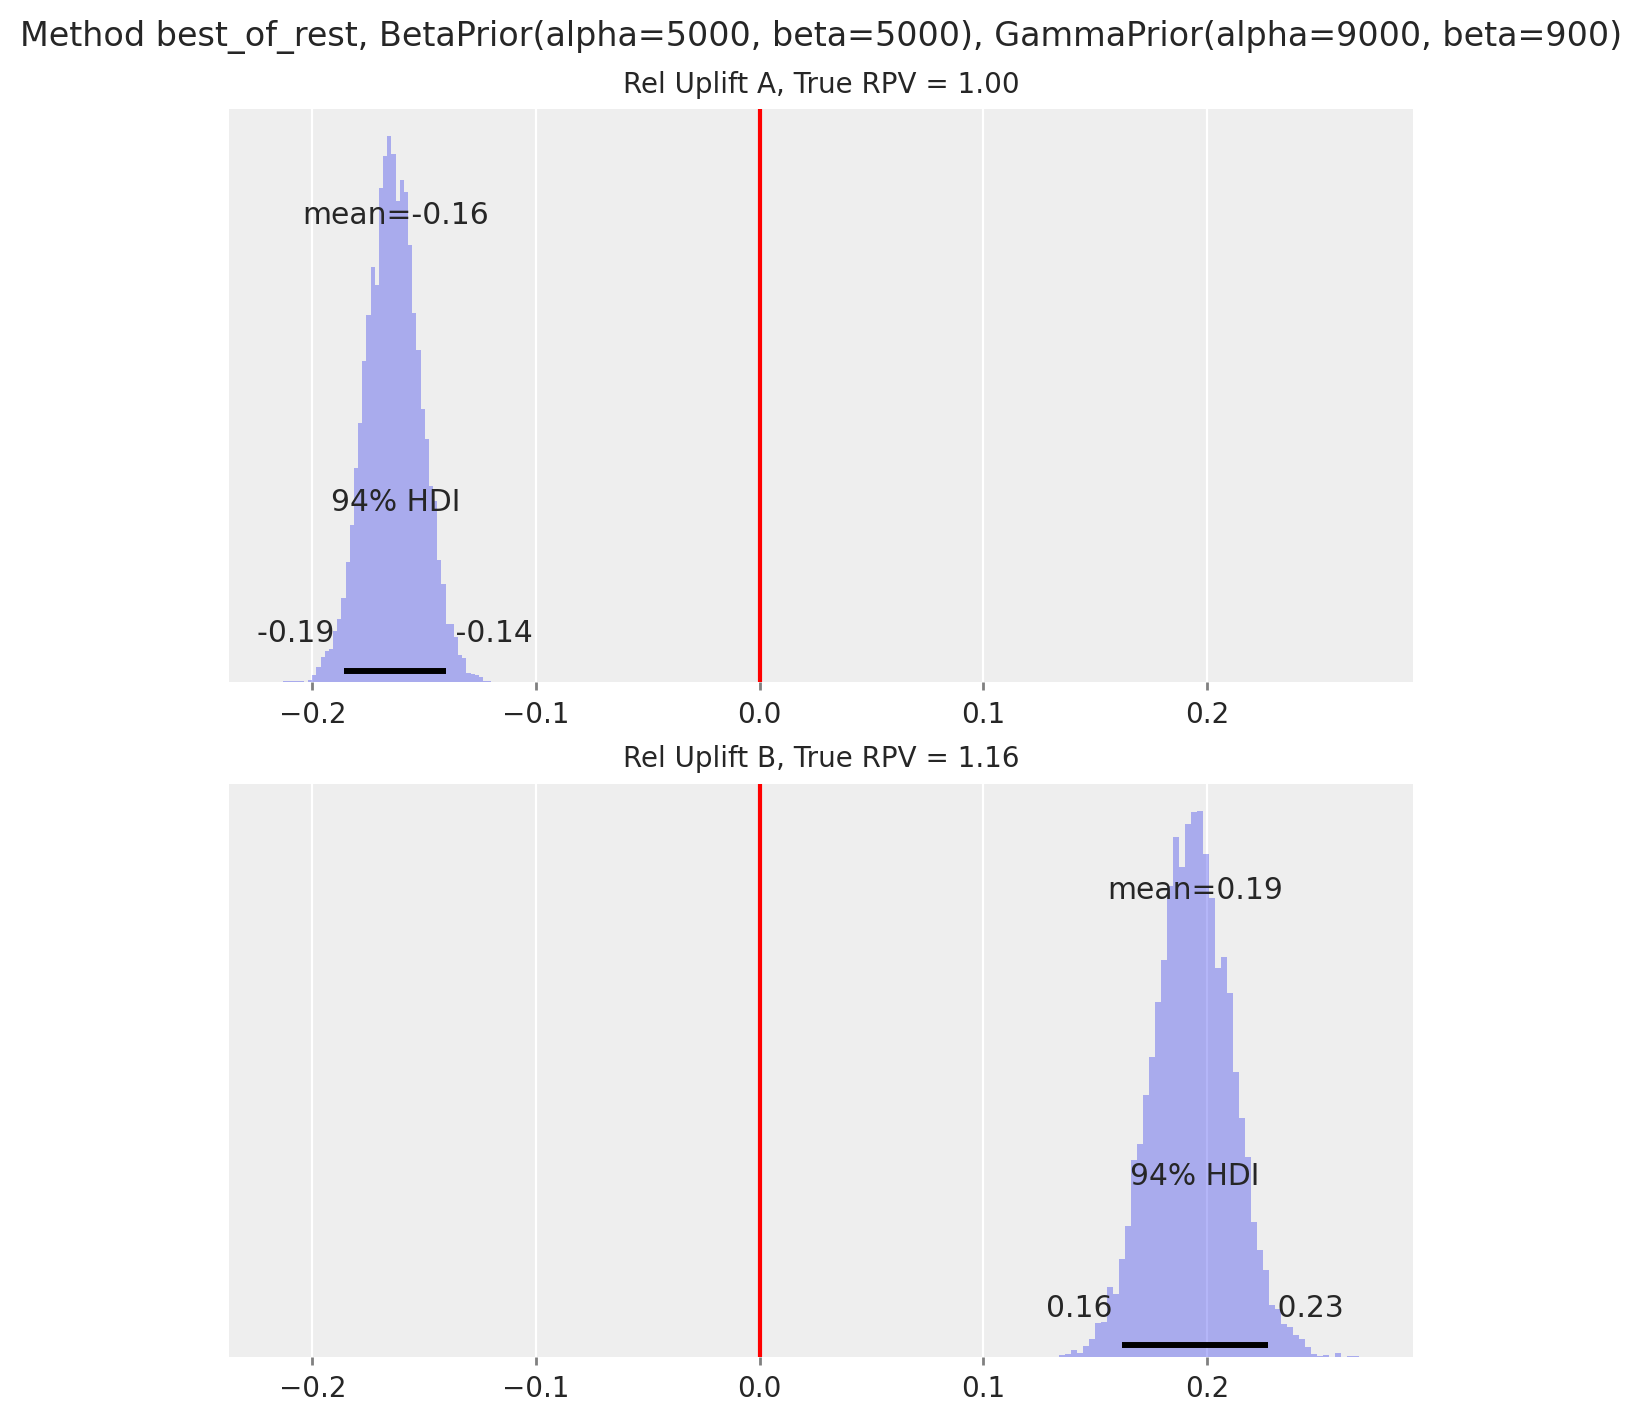

In [39]:
_ = run_scenario_value(
    variants=["A", "B"],
    true_conversion_rates=[0.1, 0.11],
    true_mean_purchase=[10, 10.5],
    samples_per_variant=100000,
    conversion_rate_prior=BetaPrior(alpha=5000, beta=5000),
    mean_purchase_prior=GammaPrior(alpha=9000, beta=900),
    comparison_method="best_of_rest",
)